In [1]:
import torch
import time 
from torch.autograd import Function
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from torchvision import datasets, transforms

## une fois le dataset telecharge, mettre download=False !
## Pour le test, train = False
## transform permet de faire un preprocessing des donnees (ici ?)
train_loader = torch.utils.data.DataLoader(datasets.MNIST('./data', train=True, download=True,\
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])), batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(datasets.MNIST('./data', train=False, download=False,\
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])), batch_size=64, shuffle=True)

torch.Size([60000, 28, 28])


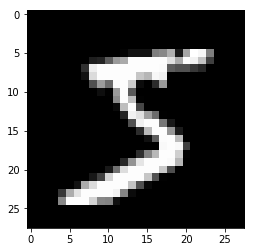

5


In [3]:
print(train_loader.dataset.train_data.size())
plt.imshow(train_loader.dataset.train_data[0].numpy(), cmap='gray')
plt.show()
print(train_loader.dataset.train_labels[0])

In [4]:
class Group(Function):
    "fonction de groupe linéaire"
    def __init__(self, l):
        "l est une liste de module"
        self.l = l
    
    def forward(self, x):
        for m in self.l:
            x = m.forward(x)
        return x
    
    def backward(self, delta):
        r = []
        for m in reversed(self.l):
            delta = m.backward(delta)
        return delta
    
    def update(self, r = 1e-3):
        for m in self.l:
            m.update(r)
            

In [5]:
class Flinear(Function):
    def __init__(self, p):
        self.p = p
    
    def forward(self, x):
        self.x = x
        return x.mm(self.p)
    
    def backward(self, delta):
        self.g = self.x.t().mm(delta)
        return delta.mm(self.p.t())
    
    def update(self, r = 1e-3):
        self.p -= r * self.g

In [6]:
class Floss(Function):
    def forward(self, yPred, y):
        self.yP = yPred
        self.y = y
        return (yPred - y) * (yPred - y)

    def backward(self):
        r = 2 * (self.yP - self.y)
        return r
    
    def update(self, r = 0):
        pass

In [7]:
class MFloss(Function):
    def forward(self, yPred, y):
        self.yP = yPred
        self.y = y
        return torch.mean((yPred - y) * (yPred - y))

    def backward(self):
        r = 2 * (self.yP - self.y)/ self.yP.size()[0]
        return r
    
    def update(self, r = 0):
        pass

In [8]:
class Htan(Function):
    def forward(self, x):
        self.x = x
        return (1 - torch.exp(-2*x))/(1+torch.exp(-2*x))
    
    def backward(self, delta):
        r = (1 - torch.exp(-2*self.x))/(1+torch.exp(-2*self.x)) * (1 - torch.exp(-2*self.x))/(1+torch.exp(-2*self.x))
        return delta * (1 - r)
    
    def update(self, r = 0):
        pass

In [9]:
class SHtan(Function):
    "htan mais de dérivé f'(x)=x"
    def forward(self, x):
        self.x = x
        return (1 - torch.exp(-2*x))/(1+torch.exp(-2*x))
    
    def backward(self, delta):
        return delta
    
    def update(self, r = 0):
        pass

In [10]:
class Sig(Function):
    def __init__(self, r = 1):
        self.r = r
    
    def forward(self, x):
        self.x = x
        return 1/(1+torch.exp(-self.r*x))
    
    def backward(self, delta):
        r = 1/(1+torch.exp(-self.r*self.x))
        return delta * r * (1-r)
    
    def update(self, r = 0):
        pass

In [11]:
class SSig(Function):
    "sigmoid mais de dérivé f'(x)=x"
    def __init__(self, r = 1):
        self.r = r
    
    def forward(self, x):
        self.x = x
        return 1/(1+torch.exp(-self.r*x))
    
    def backward(self, delta):
        return delta
    
    def update(self, r = 0):
        pass

Temps moyen de calcul par iteration : 7.6354682000000595 s


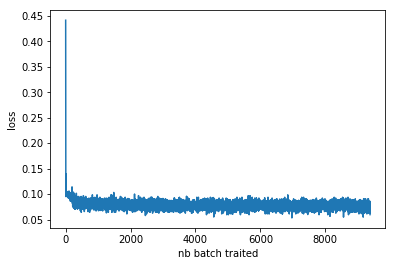

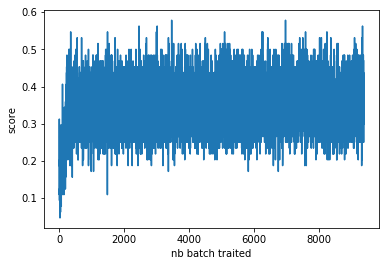

In [19]:
lamb = 1
m = Group([Flinear(torch.rand(784,10)), Sig()])
ml = Floss()
lossHisto = []
scoreHisto = []
iteration = 10
temps = []

for ite in range(iteration):
    tps1 = time.clock()
    for x,yN in train_loader:
        
        
        x = x.view(-1,784)
        
        y_onehot = torch.FloatTensor(*yN.size(), 10).zero_()
        y_onehot.scatter_(1, torch.unsqueeze(yN, 1), 1)
        y = y_onehot        
        
        f = m.forward(x)
        loss = ml.forward(f, y)
        delta = ml.backward()
        m.backward(delta)
        m.update(lamb)
        
        lossHisto.append(loss.mean())
        ypred = torch.max(f, 1)[1]
        scoreHisto.append(torch.eq(ypred, yN).float().mean())
    tps2 = time.clock() 
    temps.append(tps2 - tps1)
print("Temps moyen de calcul par iteration :", sum(temps)/len(temps), "s")
plt.plot(lossHisto)
plt.ylabel('loss')
plt.xlabel('nb batch traited')
plt.show()
plt.plot(scoreHisto)
plt.ylabel('score')
plt.xlabel('nb batch traited')
plt.show()

Temps moyen de calcul par iteration : 7.8101024 s


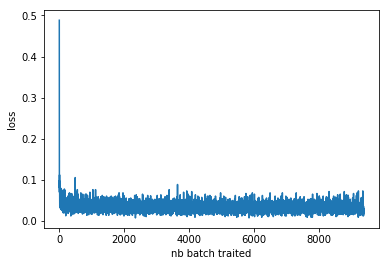

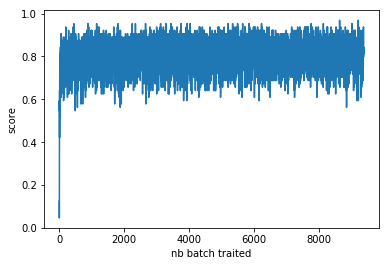

In [13]:
lamb = 1
m = Group([Flinear(torch.rand(784,10)), SSig()])
ml = Floss()
lossHisto = []
scoreHisto = []
iteration = 10
temps = []

for ite in range(iteration):
    tps1 = time.clock()
    for x,yN in train_loader:
        
        
        x = x.view(-1,784)
        
        y_onehot = torch.FloatTensor(*yN.size(), 10).zero_()
        y_onehot.scatter_(1, torch.unsqueeze(yN, 1), 1)
        y = y_onehot        
        
        f = m.forward(x)
        loss = ml.forward(f, y)
        delta = ml.backward()
        m.backward(delta)
        m.update(lamb)
        
        lossHisto.append(loss.mean())
        ypred = torch.max(f, 1)[1]
        scoreHisto.append(sum([1 for ip, i in zip(ypred, yN) if ip == i])/x.size(0))
    tps2 = time.clock() 
    temps.append(tps2 - tps1)
print("Temps moyen de calcul par iteration :", sum(temps)/len(temps), "s")
plt.plot(lossHisto)
plt.ylabel('loss')
plt.xlabel('nb batch traited')
plt.show()
plt.plot(scoreHisto)
plt.ylabel('score')
plt.xlabel('nb batch traited')
plt.show()

On peut voir dans les 2 tests ci dessus que la sigmoide avec la dérivé changé fonctionne mieux que la sigmoide normale pour le sore en train.

Temps moyen de calcul par iteration : 1168.550635 s


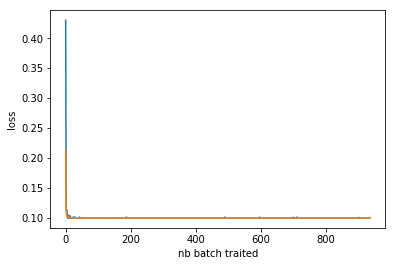

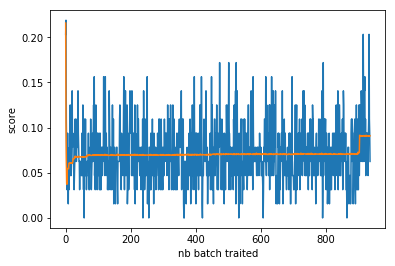

In [14]:
lamb = 1
m = Group([Flinear(torch.rand(784,10)), Sig()])
ml = Floss()
lossHisto = []
scoreHisto = []
lossTHisto = []
scoreTHisto = []
iteration = 1
temps = []

for ite in range(iteration):
    tps1 = time.clock()
    for x,yN in train_loader:
        
        
        x = x.view(-1,784)
        
        y_onehot = torch.FloatTensor(*yN.size(), 10).zero_()
        y_onehot.scatter_(1, torch.unsqueeze(yN, 1), 1)
        y = y_onehot        
        
        f = m.forward(x)
        loss = ml.forward(f, y)
        delta = ml.backward()
        m.backward(delta)
        m.update(lamb)
        
        lossHisto.append(loss.mean())
        ypred = torch.max(f, 1)[1]
        scoreHisto.append(sum([1 for ip, i in zip(ypred, yN) if ip == i])/x.size(0))
        
        tempLoss = []
        tempScore = []
        for x, yN in test_loader:
            x = x.view(-1,784)
        
            y_onehot = torch.FloatTensor(*yN.size(), 10).zero_()
            y_onehot.scatter_(1, torch.unsqueeze(yN, 1), 1)
            y = y_onehot        

            f = m.forward(x)
            ypred = torch.max(f, 1)[1]
            
            tempLoss.append(ml.forward(f, y).mean())
            tempScore.append(sum([1 for ip, i in zip(ypred, yN) if ip == i])/x.size(0))

        lossTHisto.append(sum(tempLoss)/len(tempLoss))
        scoreTHisto.append(sum(tempScore)/len(tempScore))
                
    tps2 = time.clock()
    temps.append(tps2 - tps1)

print("Temps moyen de calcul par iteration :", sum(temps)/len(temps), "s")
plt.plot(lossHisto)
plt.plot(lossTHisto)
plt.ylabel('loss')
plt.xlabel('nb batch traited')
plt.show()
plt.plot(scoreHisto)
plt.plot(scoreTHisto)
plt.ylabel('score')
plt.xlabel('nb batch traited')
plt.show()

Temps moyen de calcul par iteration : 1156.754982 s


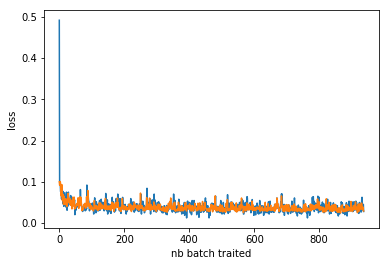

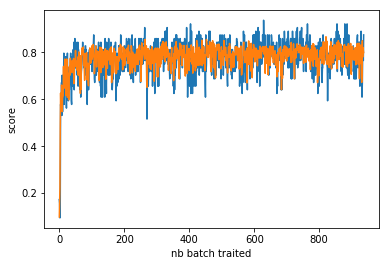

In [15]:
lamb = 1
m = Group([Flinear(torch.rand(784,10)), SSig()])
ml = Floss()
lossHisto = []
scoreHisto = []
lossTHisto = []
scoreTHisto = []
iteration = 1
temps = []

for ite in range(iteration):
    tps1 = time.clock()
    for x,yN in train_loader:
        
        
        x = x.view(-1,784)
        
        y_onehot = torch.FloatTensor(*yN.size(), 10).zero_()
        y_onehot.scatter_(1, torch.unsqueeze(yN, 1), 1)
        y = y_onehot        
        
        f = m.forward(x)
        loss = ml.forward(f, y)
        delta = ml.backward()
        m.backward(delta)
        m.update(lamb)
        
        lossHisto.append(loss.mean())
        ypred = torch.max(f, 1)[1]
        scoreHisto.append(sum([1 for ip, i in zip(ypred, yN) if ip == i])/x.size(0))
        
        tempLoss = []
        tempScore = []
        for x, yN in test_loader:
            x = x.view(-1,784)
        
            y_onehot = torch.FloatTensor(*yN.size(), 10).zero_()
            y_onehot.scatter_(1, torch.unsqueeze(yN, 1), 1)
            y = y_onehot        

            f = m.forward(x)
            ypred = torch.max(f, 1)[1]
            
            tempLoss.append(ml.forward(f, y).mean())
            tempScore.append(sum([1 for ip, i in zip(ypred, yN) if ip == i])/x.size(0))

        lossTHisto.append(sum(tempLoss)/len(tempLoss))
        scoreTHisto.append(sum(tempScore)/len(tempScore))
                
    tps2 = time.clock() 
    temps.append(tps2 - tps1)

print("Temps moyen de calcul par iteration :", sum(temps)/len(temps), "s")
plt.plot(lossHisto)
plt.plot(lossTHisto)
plt.ylabel('loss')
plt.xlabel('nb batch traited')
plt.show()
plt.plot(scoreHisto)
plt.plot(scoreTHisto)
plt.ylabel('score')
plt.xlabel('nb batch traited')
plt.show()

On peut voir que les scores et loss en test sont cohérentes avec celles en train, le modèle n'a pas de problème de généralisation (ce qui est normal vu sa simplicité).

In [16]:
lamb = 1
m = Group([Flinear(torch.rand(784,784)), Sig(), Flinear(torch.rand(784,10)), Sig()])
ml = Floss()
lossHisto = []
scoreHisto = []
lossTHisto = []
scoreTHisto = []
iteration = 1
temps = []

for ite in range(iteration):
    tps1 = time.clock()
    for x,yN in train_loader:
        
        
        x = x.view(-1,784)
        
        y_onehot = torch.FloatTensor(*yN.size(), 10).zero_()
        y_onehot.scatter_(1, torch.unsqueeze(yN, 1), 1)
        y = y_onehot        
        
        f = m.forward(x)
        loss = ml.forward(f, y)
        delta = ml.backward()
        m.backward(delta)
        m.update(lamb)
        
        lossHisto.append(loss.mean())
        ypred = torch.max(f, 1)[1]
        scoreHisto.append(sum([1 for ip, i in zip(ypred, yN) if ip == i])/x.size(0))
        
        tempLoss = []
        tempScore = []
        for x, yN in test_loader:
            x = x.view(-1,784)
        
            y_onehot = torch.FloatTensor(*yN.size(), 10).zero_()
            y_onehot.scatter_(1, torch.unsqueeze(yN, 1), 1)
            y = y_onehot        

            f = m.forward(x)
            ypred = torch.max(f, 1)[1]
            
            tempLoss.append(ml.forward(f, y).mean())
            tempScore.append(sum([1 for ip, i in zip(ypred, yN) if ip == i])/x.size(0))

        lossTHisto.append(sum(tempLoss)/len(tempLoss))
        scoreTHisto.append(sum(tempScore)/len(tempScore))
                
    tps2 = time.clock() 
    temps.append(tps2 - tps1)

print("Temps moyen de calcul par iteration :", sum(temps)/len(temps), "s")
plt.plot(lossHisto)
plt.plot(lossTHisto)
plt.ylabel('loss')
plt.xlabel('nb batch traited')
plt.show()
plt.plot(scoreHisto)
plt.plot(scoreTHisto)
plt.ylabel('score')
plt.xlabel('nb batch traited')
plt.show()

KeyboardInterrupt: 

In [ ]:
lamb = 1
m = Group([Flinear(torch.rand(784,784)), SSig(), Flinear(torch.rand(784,10)), SSig()])
ml = Floss()
lossHisto = []
scoreHisto = []
lossTHisto = []
scoreTHisto = []
iteration = 1
temps = []

for ite in range(iteration):
    tps1 = time.clock()
    for x,yN in train_loader:
        
        
        x = x.view(-1,784)
        
        y_onehot = torch.FloatTensor(*yN.size(), 10).zero_()
        y_onehot.scatter_(1, torch.unsqueeze(yN, 1), 1)
        y = y_onehot        
        
        f = m.forward(x)
        loss = ml.forward(f, y)
        delta = ml.backward()
        m.backward(delta)
        m.update(lamb)
        
        lossHisto.append(loss.mean())
        ypred = torch.max(f, 1)[1]
        scoreHisto.append(sum([1 for ip, i in zip(ypred, yN) if ip == i])/x.size(0))
        
        tempLoss = []
        tempScore = []
        for x, yN in test_loader:
            x = x.view(-1,784)
        
            y_onehot = torch.FloatTensor(*yN.size(), 10).zero_()
            y_onehot.scatter_(1, torch.unsqueeze(yN, 1), 1)
            y = y_onehot        

            f = m.forward(x)
            ypred = torch.max(f, 1)[1]
            
            tempLoss.append(ml.forward(f, y).mean())
            tempScore.append(sum([1 for ip, i in zip(ypred, yN) if ip == i])/x.size(0))

        lossTHisto.append(sum(tempLoss)/len(tempLoss))
        scoreTHisto.append(sum(tempScore)/len(tempScore))
                
    tps2 = time.clock() 
    temps.append(tps2 - tps1)

print("Temps moyen de calcul par iteration :", sum(temps)/len(temps), "s")
plt.plot(lossHisto)
plt.plot(lossTHisto)
plt.ylabel('loss')
plt.xlabel('nb batch traited')
plt.show()
plt.plot(scoreHisto)
plt.plot(scoreTHisto)
plt.ylabel('score')
plt.xlabel('nb batch traited')
plt.show()

On voit que les résultats avec une seule couche caché sont similaires (voir un peu supérieur) à ceux sans couche caché (avec la même différence à niveau de la sigmoide) mais le temps de calcul semble plus élevé (~50%).